In [1]:
import os
import sys
sys.path.append('..')
from variational_diffusion_cdm.model.networks import *
sys.path.append(os.path.expanduser("~"))
from camel_dataloader import get_astro_data,get_astro_data_2D_from_3D
from utils import draw_figure,compute_pk,plot_residual
import comet_ml
import torch
from torch import nn
from torch.nn.functional import mse_loss
from torch import autograd, Tensor
from lightning.pytorch import LightningModule, Trainer, seed_everything
from lightning.pytorch.loggers import CometLogger
from lightning.pytorch.callbacks import LearningRateMonitor, ModelCheckpoint
from typing import Optional, Tuple
from torch.special import expm1
from tqdm import trange
from torch.distributions.normal import Normal
import numpy as np
import matplotlib.pyplot as plt

device="cuda" if torch.cuda.is_available() else "mps"
print(device)
print(torch.cuda.device_count()) 

cuda
4
cuda
4


In [2]:
seed_everything(7)
cropsize = 256
batch_size = 12
num_workers = 8
   
dataset = 'Astrid'
learning_rate = 1e-3 #1e-4
gamma_min = -13.3
gamma_max = 13.3
embedding_dim = 48
norm_groups = 8
n_blocks = 4
learning_rate = 1e-3 #1e-4
noise_schedule = "learned_linear"


[rank: 0] Seed set to 7


In [3]:
dm_TF = get_astro_data_2D_from_3D(
        dataset,
        num_workers=num_workers,
        resize=cropsize,
        batch_size=batch_size,
    ) 

In [4]:
class UNetVDM_CNN(nn.Module): # with attention and fourier options
    def __init__(
        self,
        input_channels: int = 1,
        conditioning_channels: int = 1,
        embedding_dim: int=48,
        n_blocks: int = 4,  
        norm_groups: int = 8,
        n_attention_heads: int = 1,
        add_attention: bool = False,
        attention_everywhere: bool = False,
        use_fourier_features: bool = False,
        dropout_prob: float = 0.1,
        add_downsampling: bool = True,
    ):
        super().__init__()
        self.embedding_dim = embedding_dim
        self.use_fourier_features = use_fourier_features
        self.add_attention = add_attention
        self.add_downsampling = add_downsampling

        attention_params = dict(
            n_heads=n_attention_heads, #1
            n_channels=(2**n_blocks)*embedding_dim, #48
            norm_groups=norm_groups, #8
        )
        
        resnet_params = dict(
            condition_dim=4 * embedding_dim,
            dropout_prob=dropout_prob,
            norm_groups=norm_groups,
        )

        if use_fourier_features:
            self.fourier_features = FourierFeatures(
                first=-2.0,
                last=1,
                step=1,
            )

        total_input_ch = input_channels + conditioning_channels

        if use_fourier_features:
            total_input_ch *= 1 + self.fourier_features.num_features

        self.conv_in = nn.Conv2d(total_input_ch, embedding_dim, kernel_size=3, padding=1, padding_mode="circular")
        
        #Down of UNet
        self.down_blocks = nn.ModuleList()
        dim = embedding_dim #48
        for i in range(n_blocks):  #4
            self.down_blocks.append(DownBlock(resnet_block=ResnetBlock(ch_in=(dim//2 if i!=0 else dim),ch_out=dim,**resnet_params)))
            dim *= 2
        # dim = 768

        #Mid of UNet
        if self.add_attention:
            self.mid_resnet_block_1 = ResnetBlock(ch_in=dim//2,ch_out=dim,**resnet_params)
            self.mid_attn_block = AttentionBlock(**attention_params)
            self.mid_resnet_block_2 = ResnetBlock(ch_in=dim,ch_out=dim,**resnet_params)
        else:
            self.mid_resnet_block = ResnetBlock(ch_in=dim//2,ch_out=dim,**resnet_params)

        #Up of UNet
        self.up_blocks = nn.ModuleList()
        for i in range(n_blocks):
            self.up_blocks.append(UpBlock(resnet_block=ResnetBlock(ch_in=dim,ch_out=dim//2,**resnet_params)))
            dim //= 2

        self.conv_out = nn.Sequential(
            nn.GroupNorm(num_groups=norm_groups, num_channels=embedding_dim),
            nn.SiLU(),
            zero_init(nn.Conv2d(embedding_dim, input_channels, 3, padding=1, padding_mode="circular")),
        )

    def forward(self,z,conditioning=None):
        #concatenate conditioning
        if conditioning is not None:
            z_concat = torch.concat((z, conditioning),axis=1,)
        else:
            z_concat = z

        h = self.maybe_concat_fourier(z_concat)    

        #standard UNet from here but with cond at each layer
        h = self.conv_in(h)  # (B, embedding_dim, H, W)
        hs = []
        t_cond = None

        for down_block in self.down_blocks:  # n_blocks times
            h, hskip = down_block(h, cond=t_cond)
            hs.append(hskip)

        if self.add_attention:
            h = self.mid_resnet_block_1(h, t_cond)
            h = self.mid_attn_block(h)
            h = self.mid_resnet_block_2(h, t_cond)
        
        else:
            h = self.mid_resnet_block(h, t_cond)

        for up_block in self.up_blocks:  # n_blocks times
            h = up_block(x=h,xskip=hs.pop(),cond=t_cond)
        
        prediction = self.conv_out(h)
        return prediction + z

    def maybe_concat_fourier(self, z):
        if self.use_fourier_features:
            return torch.cat([z, self.fourier_features(z)], dim=1)
        return z


In [5]:
UNetVDM_model = UNetVDM_CNN(
        input_channels= 1,
        conditioning_channels = 0,
            norm_groups=norm_groups,
            n_blocks=n_blocks,
            add_attention=True,
        #use_fourier_features=True,
        )

In [ ]:
one_batch = next(iter( dm.train_dataloader()))
conditioning, x = one_batch
print(f'input: {np.shape(conditioning)}, output: {np.shape(x)}')
model_ = UNetVDM_model.eval()
out_1 = model_.conv_in(conditioning)
print(f'out_layer1:{np.shape(out_1)}')
final = model_.conv_out(out_1)
print(f'final_layer:{np.shape(final)}')

In [6]:
sys.path.append('/pscratch/sd/l/lindajin/Pytorch-UNet/unet')
from unet_model import UNet
class BasicCNN(LightningModule):
    def __init__(
        self,
        learning_rate: float = 3.0e-4,
        weight_decay: float = 1.0e-5,
        n_sampling_steps: int = 250,
        draw_figure=None,
        plot_residual=None,
        dataset='illustris',
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters(ignore=["draw_figure","plot_residual"])
        
        self.model= UNetVDM_model
        self.dataset=dataset
        print("suite:", self.dataset)
        self.draw_figure=draw_figure
        self.plot_residual=plot_residual
        if self.draw_figure is None:
            def draw_figure(args,**kwargs):
                fig=plt.figure(figsize=(5,5))
                return fig
            self.draw_figure=draw_figure

    def forward(self, x) -> Tensor:
        return self.model(x)

    def evaluate(self, batch: Tuple, stage: str = None) -> Tensor:

        cdm_map, true_map = batch
        mtot_pred = self(cdm_map)
        loss = mse_loss(mtot_pred, true_map)
        loss = loss.float()
        
        return loss

    def training_step(
        self,
        batch: Tuple,
        batch_idx: int,
    ) -> Tensor:
        return self.evaluate(batch, "train")


    def validation_step(self, batch: Tuple, batch_idx: int) -> Tensor:
        """validate model

        Args:
            batch (Tuple): batch of examples
            batch_idx (int): idx for batch

        Returns:
            Tensor: loss
        """
        conditioning, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning)
            loss = mse_loss(x, sample)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset, stage='val')
            self.log_dict({'val_loss': loss}, on_epoch=True)
            
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)
          
            plt.close()
        return loss

    def test_step(self, batch, batch_idx):
        
        conditioning, x = batch    
        loss = 0    
        
        if batch_idx == 0:
            sample = self(conditioning)
            loss = mse_loss(x, sample)
            fig = self.draw_figure(x,sample,conditioning,self.dataset)
            #fig_res = self.plot_residual(x,sample,conditioning,self.dataset)
            self.log_dict({'test_loss': loss}, on_epoch=True)
            if self.logger is not None:
                self.logger.experiment.log_figure(figure=fig)
                #self.logger.experiment.log_figure(figure=fig_res)

                loss = self.evaluate(batch, "test")
                self.logger.log_metrics({"test_loss": loss.mean()})
            plt.show()
        return self.evaluate(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(
            self.parameters(),
            lr=self.hparams.learning_rate,
            weight_decay=self.hparams.weight_decay,
        )
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
            optimizer=optimizer,
            T_0=10,

        )
        return {'optimizer': optimizer, 'lr_scheduler': scheduler}

In [7]:
cnn = BasicCNN(
        dataset=dataset,
        learning_rate=learning_rate,
        image_shape=(1,cropsize,cropsize),
        draw_figure=draw_figure,
        plot_residual=plot_residual
    )
    # Checkpoint every time val_loss improves
val_checkpoint = ModelCheckpoint(
        filename="best_model-{epoch}-{step}",
        monitor="val_loss",
         save_top_k=1, # save only the best ckpt
        mode="min",
        verbose=True,        
    )

    # Checkpoint at every 6000 steps
latest_checkpoint = ModelCheckpoint(
        filename="latest-{epoch}-{step}",
        monitor="step",
        mode="max",
        every_n_train_steps=50, #6000
        save_top_k=10
    )

comet_logger = CometLogger(
            api_key=os.environ.get("COMET_API_KEY"),
            project_name="baryonize_DM",
            experiment_name='VDM_Unet_CNN_attn',
            #offline_directory='/pscratch/sd/l/lindajin/'
        )

trainer = Trainer(
        logger=comet_logger,
        accelerator="auto",
        max_epochs=10, #1000
        gradient_clip_val=0.5,
        callbacks=[LearningRateMonitor(),
                    latest_checkpoint,
                    val_checkpoint],
    )

CometLogger will be initialized in online mode
Trainer will use only 1 of 4 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=4)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


suite: Astrid


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [8]:
trainer.fit(model=cnn, datamodule=dm_TF)

You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/2636f1e92950444a94aff66298537323

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name  | Type        | Params | Mode 
----------------------------------------------
0 | model | UNetVDM_CNN | 32.6 M | train
----------------------------------------------
32.6 M    Tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

cuda:0


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


/global/homes/l/lindajin/utils.py:225: RuntimeWarning: invalid value encountered in log
  im = ax.flat[2].imshow(np.log(sample[0].squeeze().cpu()), cmap='copper', vmin=-2, vmax=5)
Epoch 0, global step 200: 'val_loss' reached 1.15831 (best 1.15831), saving model to '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/best_model-epoch=0-step=200.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 1, global step 400: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 2, global step 600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 3, global step 800: 'val_loss' reached 1.14497 (best 1.14497), saving model to '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/best_model-epoch=3-step=800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 4, global step 1000: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 5, global step 1200: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 6, global step 1400: 'val_loss' reached 1.10476 (best 1.10476), saving model to '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/best_model-epoch=6-step=1400.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 7, global step 1600: 'val_loss' was not in top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 8, global step 1800: 'val_loss' reached 1.10271 (best 1.10271), saving model to '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/best_model-epoch=8-step=1800.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


Epoch 9, global step 2000: 'val_loss' reached 1.06013 (best 1.06013), saving model to '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/best_model-epoch=9-step=2000.ckpt' as top 1
`Trainer.fit` stopped: `max_epochs=10` reached.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : VDM_Unet_CNN_attn
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/2636f1e92950444a94aff66298537323
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     lr-AdamW [10] : (2.4471741852423235e-05, 0.001)
COMET INFO:     val_loss [10] : (1.0601316690444946, 1.4177395105361938)
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-li

In [9]:
path = trainer.checkpoint_callback.best_model_path 
print(path)

/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/latest-epoch=9-step=2000.ckpt


COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/2636f1e92950444a94aff66298537323

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/latest-epoch=9-step=2000.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

cuda:0


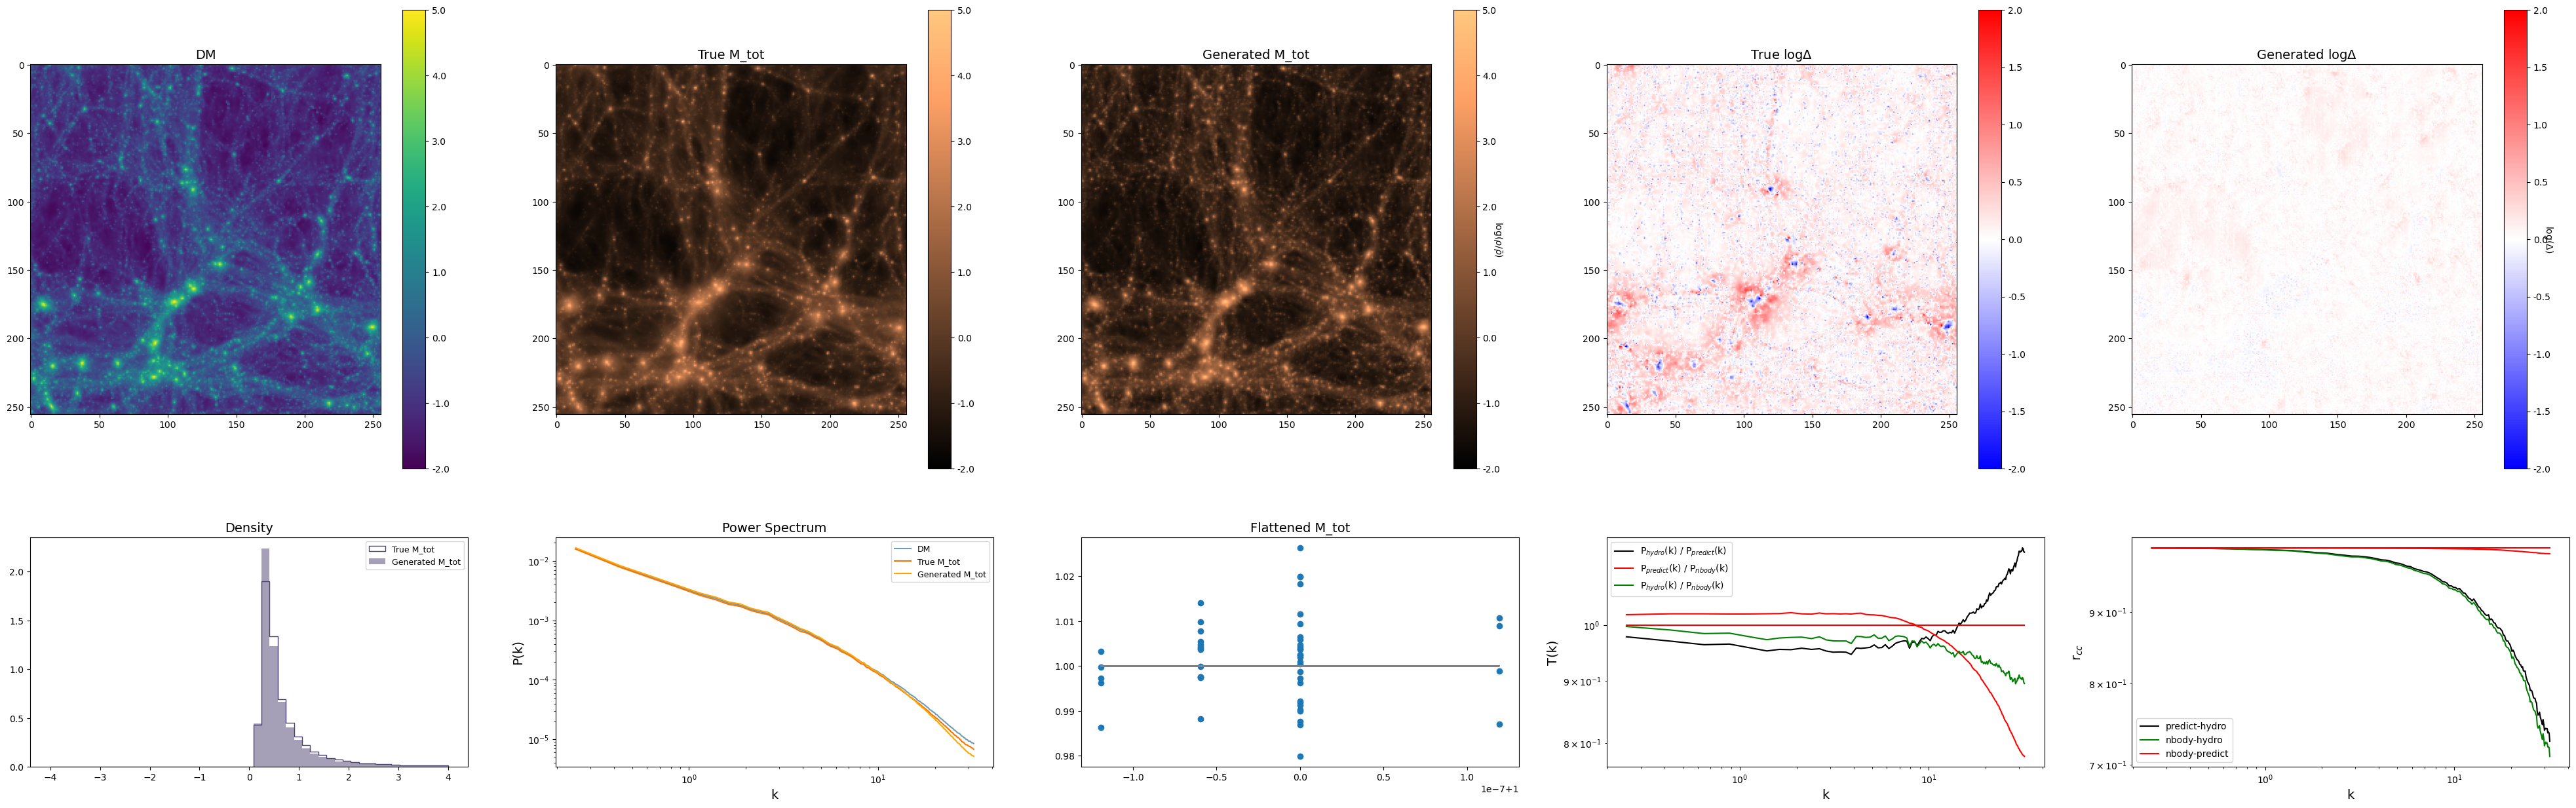

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    1.7614455223083496     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : VDM_Unet_CNN_attn
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/2636f1e92950444a94aff66298537323
COMET INFO:   Metrics:
COMET INFO:     test_loss : 1.7614455223083496
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : VDM_Unet_CNN_attn
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     n_sampling_steps : 250
COMET INFO:     weight_decay     : 1e-05
COMET INFO:   Uploads:
COMET INFO:     figures     : 1
COMET INFO:     model graph : 1
C

In [10]:
path = '/pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/latest-epoch=9-step=2000.ckpt'
test_loss = trainer.test(model=cnn, datamodule=dm_TF, ckpt_path =path)

In [11]:
trainer.validate(model=cnn, datamodule=dm_TF, ckpt_path = path)

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: torch.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/klinjin/baryonize-dm/2636f1e92950444a94aff66298537323

Restoring states from the checkpoint path at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/latest-epoch=9-step=2000.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from the checkpoint at /pscratch/sd/l/lindajin/linda_hydro_emulator/baryonize_DM/2636f1e92950444a94aff66298537323/checkpoints/latest-epoch=9-step=2000.ckpt
SLURM auto-requeueing enabled. Setting signal handlers.


Validation: |          | 0/? [00:00<?, ?it/s]

cuda:0


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         val_loss          │    1.0691713094711304     │
└───────────────────────────┴───────────────────────────┘

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml ExistingExperiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     name                  : VDM_Unet_CNN_attn
COMET INFO:     url                   : https://www.comet.com/klinjin/baryonize-dm/2636f1e92950444a94aff66298537323
COMET INFO:   Metrics:
COMET INFO:     val_loss : 1.0691713094711304
COMET INFO:   Others:
COMET INFO:     Created from : pytorch-lightning
COMET INFO:     Name         : VDM_Unet_CNN_attn
COMET INFO:   Parameters:
COMET INFO:     dataset          : Astrid
COMET INFO:     image_shape      : (1, 256, 256)
COMET INFO:     learning_rate    : 0.001
COMET INFO:     n_sampling_steps : 250
COMET INFO:     weight_decay     : 1e-05
COMET INFO:   Uploads:
COMET INFO:     figures     : 1
COMET INFO:     model graph : 1
CO

[{'val_loss': 1.0691713094711304}]

In [ ]:
trainer.logger.experiment.end()

In [ ]:
ckpt= '/global/homes/l/lindajin/baryonification_cnn/baryonize_DM/eaca96d55bbd4a30ae7f56eaab6e55d8/checkpoints/latest-epoch=9-step=10000.ckpt'
state_dict=torch.load(ckpt)["state_dict"]
cnn.load_state_dict(state_dict)
cnn.eval()